# ML in Cybersecurity: Task I

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: name1 (email1), name2 (email2), ...*


## Logistics
  * **Due date**: 11th November 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Please include your team name and the task number in the file name and the email subject
  * Complete this in **teams of 3**
  * Feel free to use the forum or the mailing list to find group members.
  
## Timeline
  * 29-Oct-2021: Task 1 hand-out
  * **11-Nov-2021** (23:59:59): Email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland
  * 12-Nov-2021: Task 1 discussion and summary
  
  
## About this task
In this task, you'll implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The dataset is based on a seminal [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), which immensely popularized (convolutional) neural networks. This is a great starting point for ML research and this dataset/model has been a stepping stone numerous other tasks such as [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), [Adversarial Perturbations](https://arxiv.org/abs/1412.6572) and so many more!

This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9. The notebook will guide you to load this data, implement classifiers $\hat{y_i} = f_w(x_i)$  and analyze results. By doing so, you'll have a ML model that works on real data!

To put things into context, have a look at Slide 21 in the [second](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf) lecture. Within this framework, the following blocks of this task are fixed:
  * *Real-world problem*: Digit classification
  * *Performance metric*: Mean accuracy i.e., $ \frac{1}{N} \sum_{i=1}^N \mathbb{1}[\hat{y_i} = y_i]$, where $\mathbb{1}[\hat{y_i} = y_i]$ is 1 if your model predicted the right digit for the $i$-th digit and 0 otherwise.
  * *Data*: The MNIST dataset

You'll make the the following design-choices:
 * *Choice of Model*: A model family (Non-parametric methods, Linear classifiers, Neural Networks, etc.)
 * *ML Model*: Specific model (e.g., SVM with a polynomial kernel)
 * *Loss/Risk*
 * *Optimization*


## A Note on Grading
The grading for this task will depend on:
 1. Functional digit classifier
   * Following a well-defined ML pipeline
   * Developing 3 classification models (keep them diverse and ideally of increasing complexity)
   * Obtaining reasonable accuracies (>80%) on a held-out test set
 1. Analysis
   * Which methods work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
    * Anything else you find interesting (this part is open-ended)
  
 A note on (1.): 
  * Choose your models that aids good insights. We require at least one non-Neural Network (e.g., SVM, KNN) and one Neural Network model (e.g., MLP, CNN).
  * We definitely don't expect all three models to achieve >99% test accuracies!

## Grading Details
 * 5 points for loading and visualization 
 * 25x3 points for models. Per model:
   * 4 points for written description 
   * 7 points for implementation
   * 7 points for evaluation
   * 7 points for summary
 * 15 points for final summary (Section 3)
 * 5 points for clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your task report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v2.0: Added pytorch
  * v1.1: Added Code of Honor
  * v1.0: Initial notebook
  
  ---

In [87]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt
import random

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd
import sklearn.neighbors

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We only support sklearn and pytorch.
import torch
import torchvision as tv

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
np.random.seed(1337)


Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [89]:
def identity_func(foo):
    return foo

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.6, 1.0)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets

def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))).astype(np.uint8)
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)
    plt.tight_layout() 

def get_index_for_value(i: int, y_trainval):
    indeces = np.where(y_trainval==i)[0]
    return np.random.choice(indeces)
    
def fit_all_models(mds, x, y):
    for model in mds:
        model.fit(x, y)

def flatten_sets(x_t, x_e, y_t, y_e):
    x_t_f = flatten_input_pixels(x_t)
    x_e_f = flatten_input_pixels(x_e)
    y_t_f = [i[0] for i in y_t]
    y_e_f = [i[0] for i in y_e]
    return x_t_f, x_e_f, y_t_f, y_e_f

# 1. Loading and Visualizing data (5 points)

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist).
  
  
  In either case, it is important that you have disjoint train, val, and test splits!

In [90]:
train = tv.datasets.MNIST(".", train=True, download=True)
test = tv.datasets.MNIST(".", train=False, download=True)
x_trainval = list()
y_trainval = list()
x_test = list()
y_test = list()

random.seed(42)

trainval_idxs = list(range(0, len(train)))
random.shuffle(trainval_idxs)
test_idxs = list(range(0, len(test)))
random.shuffle(test_idxs)

for i in trainval_idxs:
    x_trainval.append(np.array(train[i][0]))
    y_trainval.append([train[i][1]])
    
x_trainval = np.array(x_trainval)
y_trainval = np.array(y_trainval)
    
for i in test_idxs:
    x_test.append(np.array(test[i][0]))
    y_test.append([test[i][1]])
    
x_test = np.array(x_test)
y_test = np.array(y_test)


print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 1.0
x_trainval = x_trainval[:int(len(x_trainval)*DEBUG_FRAC)]
y_trainval = y_trainval[:int(len(y_trainval)*DEBUG_FRAC)]

random_seed = 1337

x_trainval.shape = (60000, 28, 28),  y_trainval.shape = (60000, 1)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000, 1)


#### 1.2. Visualize Data

To get the hang of your data you'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid (e.g., Slide 4, [Lecture 2](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf)) using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

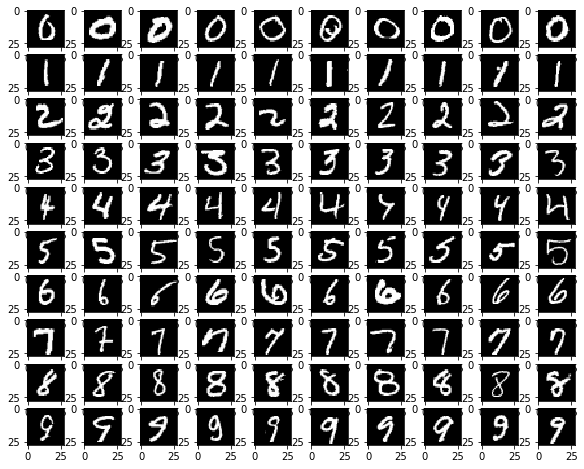

In [91]:
# Visualize 10 examples of 10 classes. You can extend the following code:

rows, cols = 10, 10
fig,ax = plt.subplots(nrows = rows, ncols = cols)

for i in range(rows):
    for j in range(cols):
        index = get_index_for_value(i, y_trainval)
        ax[i][j].imshow(x_trainval[index])

plt.savefig('fig1.pdf')   # Save the figures
plt.show()   # These should be some visualization of data at the end of this section

# 2. Digit classifiers

In this section, you'll begin developing models to perform digit classification.

Each model needs to be structured like so:
  1. Give a brief reason which model you are going to train and why you choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define your model
  1. Define optimization method and fit model to data
  1. Summarize your findings

## 2.1: Model [M1] kNearestNeighbors:  (25 points)

**Short description **: *fill this in*

### 2.1.1: Hyper-parameters

Define hyper-parameters for your model here

In [126]:
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

test_set = 'val'  #  or 'test'
k_s = np.asarray(range(1, 10)) if test_set == 'val' else np.asarray([3])

TESTING_FRAC = 0.1
LEN = len(x_trainval)

if test_set == 'val':
    train_idxs, val_idxs = range(int(LEN * TESTING_FRAC), LEN), range(0, int(LEN * TESTING_FRAC))   # Fill in
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.1.2: Data Preprocessing

In [127]:
# bring data into shape

x_train_flat, x_eval_flat, y_train_flat, y_eval_flat = flatten_sets(x_train, x_eval, y_train, y_eval)

### 2.1.3: Model

Define your model here

In [128]:
models = [sklearn.neighbors.KNeighborsClassifier(n_neighbors=k) for k in k_s]

### 2.1.4: Fit Model

Define optimization procedure and fit your model to the data

In [129]:
fit_all_models(models, x_train_flat, y_train_flat)

### 2.1.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot the score (accuracy) for each model using "plot_scores" function
  * Report score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions

In [130]:
scores = list()
for i in range(len(models)):
    scores.append(models[i].score(x_eval_flat, y_eval_flat))

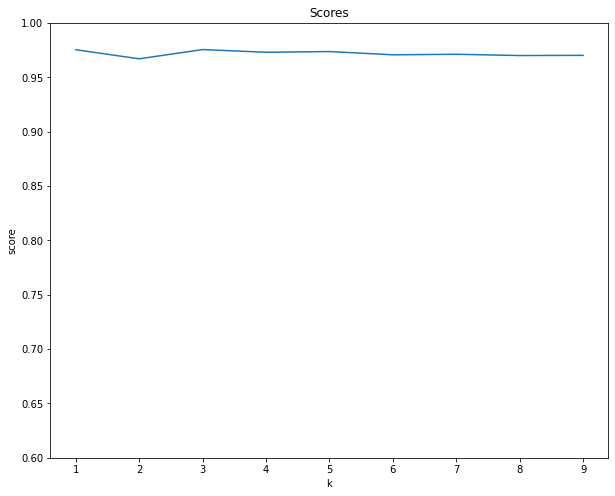

In [131]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.

plot_scores(k_s, scores, title="Scores", x_label="k", y_label="score")

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.

In [132]:
# Here report the score for the best model

max_score = max(scores)
best_k_index = scores.index(max_score)

print(f"The best score is achieved with k = {k_s[best_k_index]} with a score of {max_score}")

The best score is achieved with k = 3 with a score of 0.9755


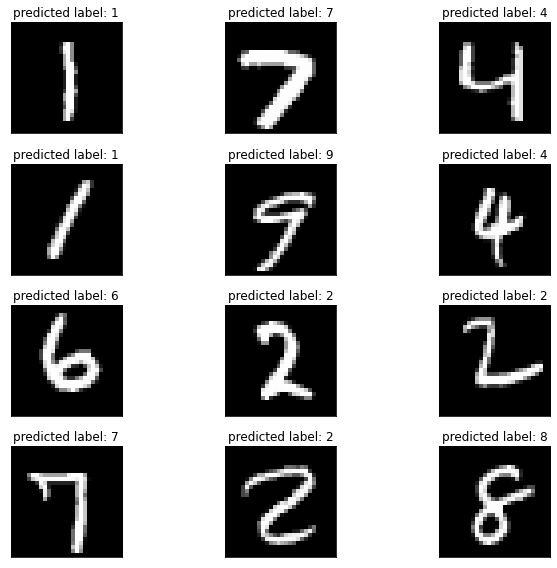

In [133]:
# Visualize the predictions

x_test_flat = flatten_input_pixels(x_test)

prediction = models[best_k_index].predict(x_test_flat)
vis_predictions(x_test_flat, prediction, len(x_test_flat))

### 2.1.6: Summary

Summarize your findings:

* The k parameter was important for kNN :). More or less all values between 1 and 10 worked just fine but we found that k = 3 was the best.
* We choose to flatten the input such that we only had a one dimensional vector and not a multi-dimensional one.

# 2.2: Model [M2]: SVM (25 points)

### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [134]:
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

test_set = 'val'  #  or 'test'
kernels = np.asarray(["linear", "poly", "rbf"]) if test_set == 'val' else np.asarray(["rbf"])

if test_set == 'val':
    train_idxs, val_idxs = range(6_000, 25_000), range(0, 6_000)   # Fill in
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.2.2: Data Preprocessing


In [135]:
# bring data into shape

x_train_flat, x_eval_flat, y_train_flat, y_eval_flat = flatten_sets(x_train, x_eval, y_train, y_eval)

### 2.2.3: Model

Define your model here (all hyper-parameters in 2.1.1)

In [136]:
models = [sklearn.svm.SVC(kernel=k, cache_size=10_000, random_state=random_seed) for k in kernels]

### 2.2.4: Fit Model

In [137]:
#  Please save the trained model

fit_all_models(models, x_train_flat, y_train_flat)

### 2.2.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions

In [138]:
scores = list()
for i in range(len(models)):
    scores.append(models[i].score(x_eval_flat, y_eval_flat))

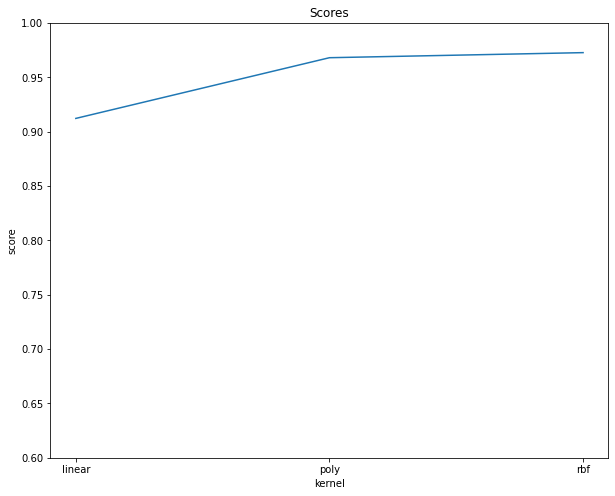

In [139]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.

plot_scores(kernels, scores, title="Scores", x_label="kernel", y_label="score")

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.

In [140]:
# Here report the score for the best model

max_score = max(scores)
best_kernel_index = scores.index(max_score)

print(f"The best score is with achieved with kernel {kernels[best_kernel_index]} with {max_score}")

The best score is with achieved with kernel rbf with 0.9726666666666667


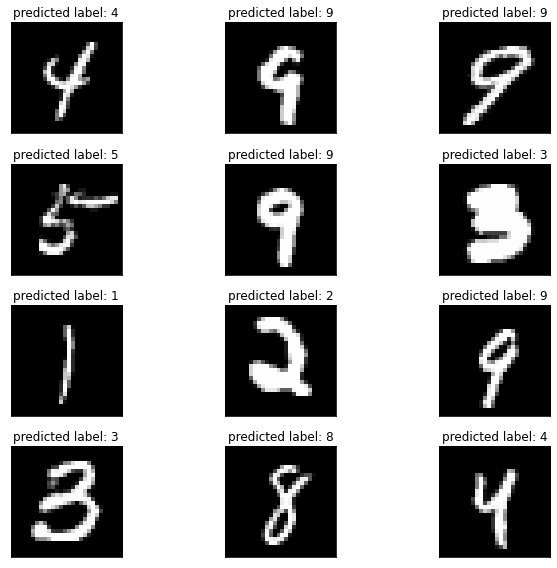

In [141]:
# Visualize the predictions

x_test_flat = flatten_input_pixels(x_test)

prediction = models[best_kernel_index].predict(x_test_flat)
vis_predictions(x_test_flat, prediction, len(x_test_flat))

### 2.2.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

# 2.3: Model [M3] (Neural Networks): *fill-this-in* (25 points)



### 2.3.1: Hyper-parameters

Define hyper-parameters for your method here

In [ ]:
#
#
# ------- Your Code -------
#
#
batch_size_train = ... # Fill in
batch_size_test = ... # Fill in
n_epochs = ... # Fill in
# other parameters ...


# You don't need the following code, if you can use data from 2.1.1.
# You can also use torch built-in functions (torch.utils.data)

test_set = 'val'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    train_idxs, val_idxs = ..., ...   # Fill in
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.3.2: Data Preprocessing


In [ ]:
#
#
# ------- Your Code -------
#
# e.g. normalize, flatten input data.


### 2.3.3: Model

Define your model here

In [ ]:
class Net(nn.Module):
    #
    #
    # ------- Your Code -------
    #
    #

### 2.2.4: Fit Model


In [ ]:
#
#
# ------- Your Code -------
#
# Example: net = Net(), ....

In [ ]:
def train(args ... # Fill in):
    #
    #
    # ------- Your Code -------
    #


In [ ]:
def test(args ... # Fill in):
    #
    #
    # ------- Your Code -------
    #

In [ ]:
# Save your model using torch.save()

### 2.2.5: Evaluation

Evaluate your model.

  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

In [ ]:
# Here plot epoch (# passes over training data) and loss
#
# ------- Your Code -------
#

In [ ]:
# Here plot epoch and accuracy over val/test set
#
# ------- Your Code -------
#

In [ ]:
#
#
# ------- Your Code -------
# Example:
# net = Net()
# net.load_state_dict(torch.load("PATH"))

In [ ]:
# Here report the score for the best model
#
# ------- Your Code -------
#

In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
#
# ------- Your Code -------
#

### 2.3.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

# 3. Summary (20 points)

Enter your final summary here.

You should now compare performance  on the three models [M1], [M2] and [M3]. Present this in a tabular format and/or using plots.

Which model do you recommend to perform digit classification and why?

Feel free to discuss other insightful observations.